In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features
y = winequality.data.targets

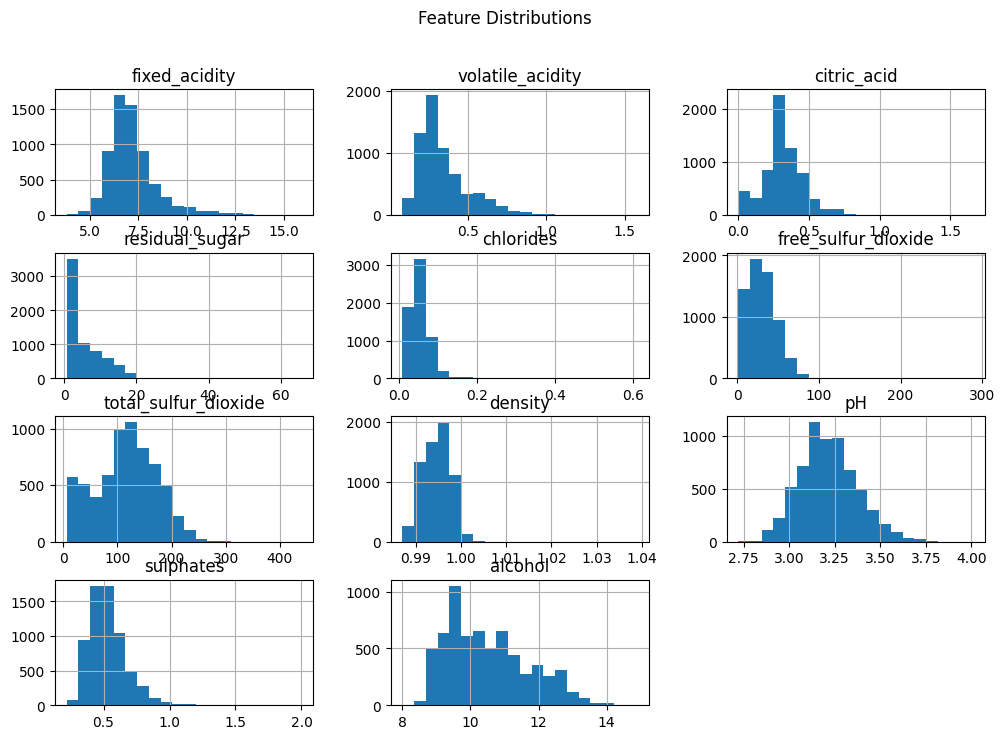

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

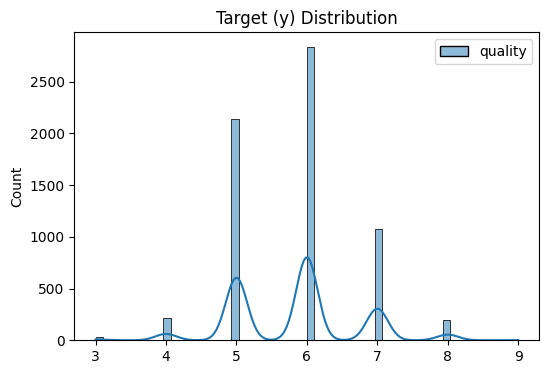

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

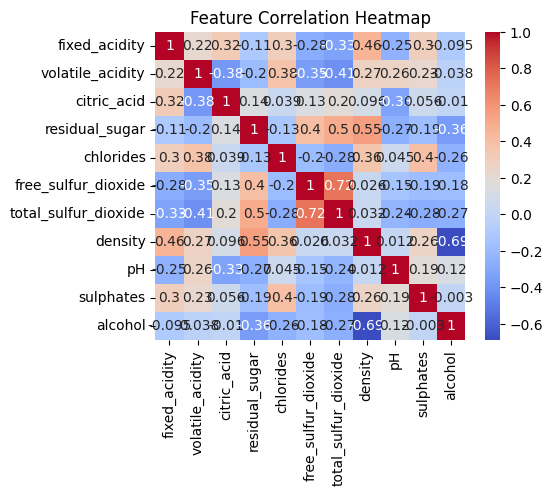

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.388894                 1.130570             1.297718   
1                  1.592246                 1.126769             1.385321   
2                  1.217322                 1.104769             1.115806   
3                  1.182883                 1.189483             1.068732   
4                  1.305912                 1.031848             1.174512   
5                  1.151171                 1.132978             1.069248   
6                  1.196167                 1.145025             1.171386   
7                  1.064719                 1.162341             1.179836   
8                  1.212601                 1.113415             1.072793   
9                  1.176281                 1.067445             1.226179   
mean               1.248820                 1.120464             1.176153   
std                0.148674              

In [10]:
rhat_df.to_csv("results/real2_WineQuality_rhat.csv", index=False)

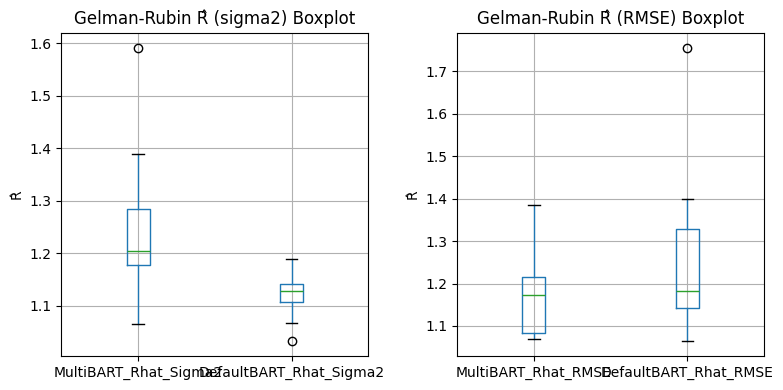

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.468528  0.468516  0.476685  0.389235  0.423869
1      0.443610  0.459402  0.463041  0.359287  0.416377
2      0.471564  0.492860  0.494605  0.384622  0.407832
3      0.437676  0.454012  0.462256  0.346424  0.386311
4      0.444724  0.453831  0.455026  0.363344  0.391157
5      0.436299  0.454692  0.468411  0.369662  0.415728
6      0.459156  0.473871  0.481846  0.377460  0.403745
7      0.472414  0.480910  0.477520  0.379783  0.425224
8      0.413828  0.427532  0.444487  0.332221  0.366885
9      0.489693  0.506245  0.498259  0.427461  0.448023
mean   0.453749  0.467187  0.472214  0.372950  0.408515
std    0.022475  0.022511  0.016940  0.026017  0.022950



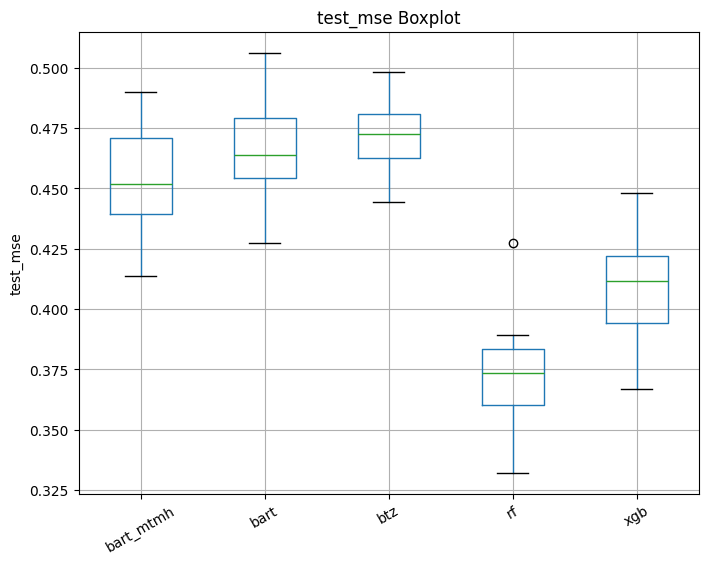

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.294702  0.363664  0.405461  0.051776  0.063149
1      0.287691  0.371106  0.415851  0.053084  0.067435
2      0.292405  0.371284  0.400854  0.051887  0.057334
3      0.303454  0.373211  0.419258  0.054751  0.057431
4      0.296825  0.377811  0.411875  0.051670  0.068970
5      0.300048  0.382307  0.409502  0.051974  0.068156
6      0.290887  0.373961  0.405331  0.051510  0.060060
7      0.295979  0.362532  0.405558  0.051897  0.070524
8      0.312007  0.389067  0.428525  0.053018  0.065569
9      0.284197  0.355194  0.393874  0.049368  0.059666
mean   0.295819  0.372014  0.409609  0.052093  0.063829
std    0.008011  0.009885  0.009838  0.001376  0.004957



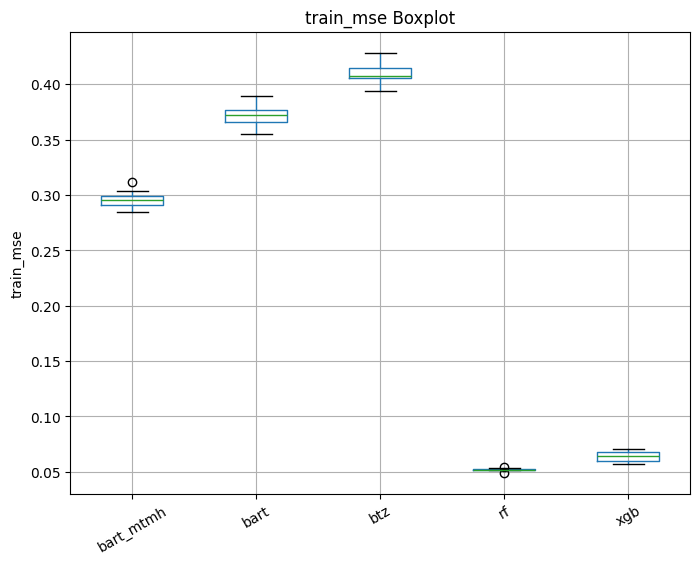

pi_length:
      bart_mtmh      bart       btz
0      2.475319  2.540630  2.654153
1      2.469054  2.572612  2.670729
2      2.455174  2.561008  2.647047
3      2.520098  2.579669  2.679661
4      2.489619  2.579604  2.658016
5      2.488013  2.596988  2.656273
6      2.474619  2.565647  2.662798
7      2.477649  2.553943  2.653668
8      2.533176  2.624593  2.707983
9      2.446717  2.519440  2.636817
mean   2.482944  2.569413  2.662714
std    0.026679  0.029201  0.019820



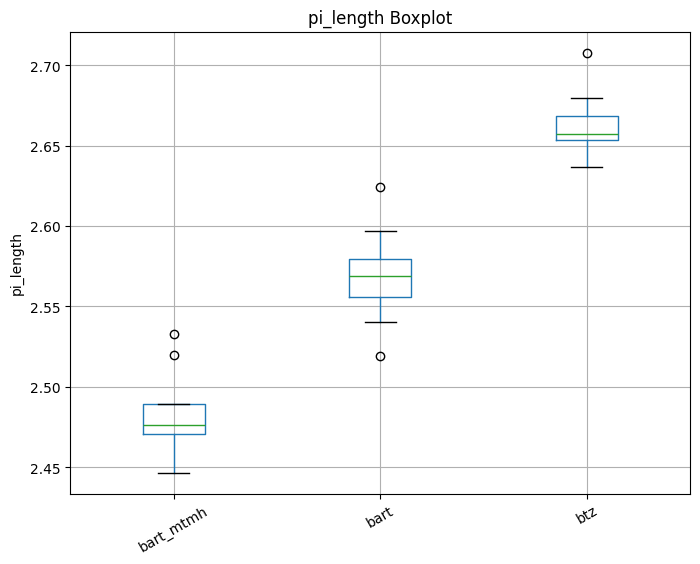

coverage:
      bart_mtmh      bart       btz
0      0.931692  0.934769  0.942154
1      0.934154  0.939692  0.948308
2      0.926769  0.932308  0.939692
3      0.942769  0.942154  0.944615
4      0.937846  0.942154  0.945231
5      0.938462  0.941538  0.937231
6      0.929846  0.932923  0.937231
7      0.929231  0.937231  0.942154
8      0.948308  0.952615  0.954462
9      0.922462  0.922462  0.937846
mean   0.934154  0.937785  0.942892
std    0.007795  0.007984  0.005503



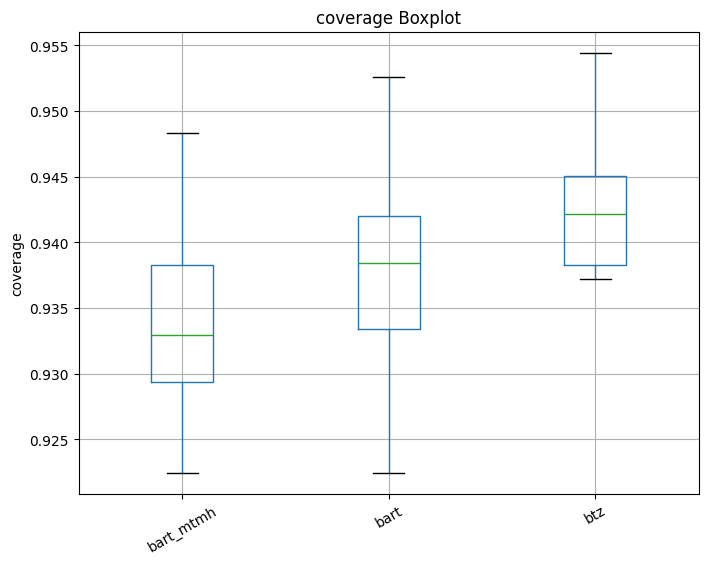

train_time:
       bart_mtmh       bart        btz         rf       xgb
0     305.662079  51.658948  52.639694  13.214518  0.809236
1     307.032929  52.529810  57.454544   9.359020  0.447211
2     308.382842  52.293270  58.735167   8.698467  0.870821
3     311.376143  55.970279  65.201418   4.558079  0.424870
4     309.607861  54.268225  61.109269   7.487337  0.479765
5     311.211353  54.823505  63.891119   5.129500  0.449485
6     314.611258  96.658979  42.482933   3.647775  0.419112
7     309.793604  55.097787  62.590281   6.281247  0.541046
8     309.919259  55.501960  61.850448   6.399560  0.530756
9     312.558684  59.988378  72.307280   3.541249  0.366071
mean  310.015601  58.879114  59.826215   6.831675  0.533837
std     2.616368  13.483486   7.984901   2.991904  0.170029



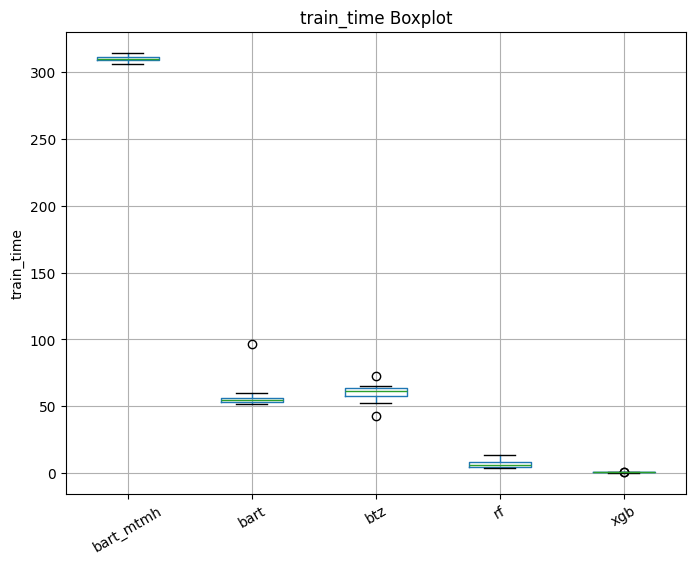

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=-2)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real2_WineQuality_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real2_WineQuality_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real2_WineQuality_tries.csv", index=False)

In [ ]:
print(df)